# CSE574 Intro to Machine Learning Project 3
### Train unsupervised models: kmeans, auto-encoder based kmeans and gmm using Fashion-MNIST clothing images 
### author: Utkarsh Behre (ubehre@buffalo.edu)

### Task 1: Use KMeans algorithm to cluster original data space of Fashion-MNIST dataset

#### Importing libraries and loading data

In [33]:
# Read Fashion MNIST dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import completeness_score
# Below code can be used to get data from local files by uncommenting section 2
# Section 1
# import util_mnist_reader as mnist_reader
# X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
# X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

# Below code can be used to get data from tensorflow datasets directly when running in google collab
# Section 2
import tensorflow as tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28) y_train shape: (60000,)


#### preprocessing the dataset

In [34]:
# First we reshape the 28x28 images to 784 pixel values
X_train = X_train.reshape(60000,784)
X_test = X_test.reshape(10000,784)

# then we normalize the values
print("Min and Max values of train and test set before normalizing: ", np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test))
X_train = X_train/np.max(X_train)
X_test = X_test/np.max(X_test)
print("Min and Max values of train and test set after normalizing: ", np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test))

# print final shapes of training set and testing set
print("X_train shape: ", X_train.shape, ", y_train shape: ", y_train.shape,", X_test shape: ", X_test.shape, ", y_test shape: ", y_test.shape)

Min and Max values of train and test set before normalizing:  0 255 0 255
Min and Max values of train and test set after normalizing:  0.0 1.0 0.0 1.0
X_train shape:  (60000, 784) , y_train shape:  (60000,) , X_test shape:  (10000, 784) , y_test shape:  (10000,)


#### make the kmeans model using sklearn library and fit the model

In [35]:
#tol is the relative tolerance required to make sure it doesnt take too much time to find convergence
kmeans = KMeans(n_clusters=10, init='random', max_iter=100, tol=0.0001)
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=100,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### test the model on test dataset and get accuracy of the model

In [36]:
y_predict_train = kmeans.labels_
y_predict_test = kmeans.predict(X_test)

score1 = 100 * completeness_score(y_train, y_predict_train)
score2 = 100 * completeness_score(y_test, y_predict_test)

conf_matrix = confusion_matrix(y_predict_test, y_test)
print(conf_matrix)
print("Task1: Accuracy on the Training dataset", score1)
print("Task1: Accuracy on the Testing dataset", score2)

[[  5   0   4   3   5   0   0   0 408   2]
 [ 29 890   4 503  27   0  12   0   6   0]
 [587  50  19 277 136   0 189   0   3   0]
 [ 34   9 566  10 627   0 312   0  62   0]
 [ 93  22  61  92  42 649 115  62  84  29]
 [245  29 342 113 159   6 357   0  36   4]
 [  0   0   0   0   0  44   0   2   1 407]
 [  6   0   4   2   4   0  15   0 351   0]
 [  1   0   0   0   0 229   0 791  42  26]
 [  0   0   0   0   0  72   0 145   7 532]]
Task1: Accuracy on the Training dataset 52.37642972025175
Task1: Accuracy on the Testing dataset 52.4709193770049


### Task 2 and Task 3's Auto-Encoder part: Build an Auto-Encoder to have the condensed representation of the unlabeled fashion MNIST dataset

#### Importing required libraries for task 2 and loading the dataset

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# use below code when running in local
# import util_mnist_reader as mnist_reader
# X_train, y_train = mnist_reader.load_mnist_for_CNN('data/fashion', kind='train')
# X_test, y_test = mnist_reader.load_mnist_for_CNN('data/fashion', kind='t10k')

# Load the fashion-mnist data from keras dataset | use this when using google collab
import tensorflow as tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28) y_train shape: (60000,)


#### preprocessing the data

In [4]:
# reshaping so that it can be fed to auto-encoder
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

# type change to support in keras
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
print(X_train.shape, X_train.dtype, X_test.shape, X_test.dtype)

# normalize the data
print(np.max(X_train), np.max(X_test))
X_train = X_train/np.max(X_train)
X_test = X_test/np.max(X_test)
print(np.max(X_train), np.max(X_test))

# split data into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=13)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(60000, 28, 28, 1) float32 (10000, 28, 28, 1) float32
255.0 255.0
1.0 1.0
(48000, 28, 28, 1) (12000, 28, 28, 1) (48000,) (12000,)


#### encoder, decoder and other functions common to Task 2 and Task 3

In [0]:
# for task 3 too much ram requirement for conv4, so removing it for task 3
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    return conv3

def decoder(conv3): 
    #decoder
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

def flatten(enco):
    out = Flatten()(enco)
    return out

#### defining our auto-encoder model

In [6]:
# setting different parameters' values for the model
batch_size = 480
epochs = 200
input_img = Input(shape = (28,28,1))
num_classes = 10

# define the auto-encoder model
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

# print the summary/architecture of the autoencoder we are using
autoencoder.summary()















Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)

#### train the auto-encoder model

In [7]:
autoencoder_train = autoencoder.fit(X_train, X_train, batch_size=480, epochs=epochs, verbose=1,validation_data=(X_valid, X_valid))



Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 7s 139us/step - loss: 0.0292 - val_loss: 0.0301
Epoch 2/200
48000/48000 [==============================] - 3s 52us/step - loss: 0.0126 - val_loss: 0.0150
Epoch 3/200
48000/48000 [==============================] - 2s 52us/step - loss: 0.0089 - val_loss: 0.0077
Epoch 4/200
48000/48000 [==============================] - 2s 52us/step - loss: 0.0071 - val_loss: 0.0080
Epoch 5/200
48000/48000 [==============================] - 2s 52us/step - loss: 0.0062 - val_loss: 0.0067
Epoch 6/200
48000/48000 [==============================] - 3s 52us/step - loss: 0.0058 - val_loss: 0.0054
Epoch 7/200
48000/48000 [==============================] - 2s 52us/step - loss: 0.0052 - val_loss: 0.0049
Epoch 8/200
48000/48000 [==============================] - 2s 52us/step - loss: 0.0052 - val_loss: 0.0046
Epoch 9/200
48000/48000 [==============================] - 3s 52us/step - loss: 0.0049 - val_loss: 

#### Draw the training and validation loss vs epochs graph for training the auto-encoder

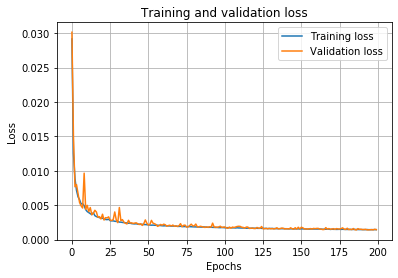

In [8]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(b=None, which='major', axis='both')
plt.legend()
plt.show()

#### Make only an encoder model using the same structure and weights as before with just an addition of flatten layer

In [9]:
encode = encoder(input_img)
encoder_model = Model(input_img,flatten(encode))
#encoder_model.layers
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0   

In [10]:
# copy the weights from previously trained autoencoder model to our new model
for l1,l2 in zip(encoder_model.layers[:8],autoencoder.layers[0:8]):
    l1.set_weights(l2.get_weights())
    
# Run this to confirm weights are same in our new encoder model with flatten layer
print(autoencoder.get_weights()[0][1])
print(encoder_model.get_weights()[0][1])

[[[ 0.09191477  0.23197442 -0.08947357 -0.1581791  -0.14265007
   -0.19768147  0.06695522  0.08693453  0.05137896  0.14320579
   -0.17349476 -0.07924609  0.3161732   0.14687526 -0.24022019
   -0.18729201  0.05606147 -0.0321879  -0.09309539 -0.04845624
   -0.11965645 -0.02582127  0.1289782   0.12898305 -0.03124579
    0.12503724  0.09124305  0.14769474  0.02310151  0.2112457
   -0.08924935 -0.29200545]]

 [[ 0.2848723   0.04996274 -0.11579301 -0.24367012  0.02214088
   -0.3471586  -0.34291843  0.08075299  0.13557595 -0.26784047
    0.26401252 -0.19768183  0.33575526 -0.1345207   0.14186315
   -0.05032038  0.0657806   0.32597068  0.12444524  0.0118987
    0.18314804 -0.00560663  0.3168614  -0.17797226 -0.19981682
    0.15602612  0.07787874 -0.12149646  0.581587   -0.15753789
    0.2997621  -0.2215946 ]]

 [[ 0.15653999  0.18192233  0.2468831  -0.01801955  0.1347526
   -0.36348483 -0.21699096  0.19597593 -0.17635335  0.16301125
   -0.18072025 -0.03765305 -0.19984914 -0.0954921   0.0384335

#### Use the encoder model to get the training input for the kmeans and Gaussian mixture models

In [0]:
encoded_output = encoder_model.predict(X_train)
#encoded_output.shape

### Task 2: Build an Auto-Encoder based K-Means clustering model to cluster the condensed representation of the unlabeled fashion MNIST dataset

#### Define the KMeans model and fit the model using the encoded_output found

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init='random', max_iter=100, tol=0.0001)
kmeans.fit(encoded_output)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=100,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### Find the accuracy of the KMeans model for Task 2

In [29]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import confusion_matrix
y_predict_train = kmeans.labels_
y_predict_test = kmeans.predict(encoder_model.predict(X_test))

# print(y_predict_train.shape, y_train.shape)
score1 = 100 * completeness_score(y_train, y_predict_train)
score2 = 100 * completeness_score(y_test, y_predict_test)
conf_matrix = confusion_matrix(y_predict_test, y_test)
print(conf_matrix)
print("Task 2: Accuracy on the Training dataset", score1)
print("Task 2: Accuracy on the Testing dataset", score2)

[[517  41  14 268 115   0 160   0   3   1]
 [  0   0   0   0   0  81   0  39   0 816]
 [153  23 298  64 206   6 261   0  25   5]
 [  5   0   3   1   4   0   2   0 403   1]
 [ 30 814   4 457  24   0  20   0   4   0]
 [  2   0   0   0   0 737   5 174  58  62]
 [  3   0   3   1   4   4  12   2 331   2]
 [  1   0   0   0   0 162   0 785  45 108]
 [252 115 197 201  95  10 278   0  76   3]
 [ 37   7 481   8 552   0 262   0  55   2]]
Task 2: Accuracy on the Training dataset 52.44530623129291
Task 2: Accuracy on the Testing dataset 51.87130739865332


### Task 3: Build an Auto-Encoder based Gaussian Mixture Model clustering model to cluster the condensed representation of the unlabeled fashion MNIST dataset

#### Define the Gaussian Mixture model

In [13]:
from sklearn import mixture
# 'spherical' 'tied' 'diag' 'full'
cv_type = 'diag'
gmm = mixture.GaussianMixture(n_components=10, covariance_type=cv_type)
gmm.fit(encoded_output)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

#### Find the accuracy of the Gaussian Mixture model for Task 3

In [30]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import confusion_matrix

y_predict_train = gmm.predict(encoder_model.predict(X_train))
y_predict_test = gmm.predict(encoder_model.predict(X_test))

score1 = 100 * completeness_score(y_train, y_predict_train)
score2 = 100 * completeness_score(y_test, y_predict_test)

conf_matrix = confusion_matrix(y_predict_test, y_test)
print(conf_matrix)
print("Task 3: Accuracy on the Training dataset", score1)
print("Task 3: Accuracy on the Testing dataset", score2)

[[  0   0   0   0   0 536   0 921   5  95]
 [ 90 107   9 621  67   0  64   0  13   0]
 [ 23   4  23   3  12   4  48   7 437   3]
 [  8   0   7  11  16   0   8   0 450   0]
 [  0   0   0   0   0 346   0  67   2 886]
 [ 60  37  41  58  37 114  58   5  72  15]
 [181   4 275  46 107   0 273   0   0   1]
 [602  18  17 171  92   0 190   0   3   0]
 [ 33   7 628  12 666   0 357   0  18   0]
 [  3 823   0  78   3   0   2   0   0   0]]
Task 3: Accuracy on the Training dataset 58.26739037127447
Task 3: Accuracy on the Testing dataset 56.258316333777444
